In [6]:
# !gdown --id 1TXuHJmCvxR8f3jwamPtYmueLlViqhk7n

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1TXuHJmCvxR8f3jwamPtYmueLlViqhk7n
From (redirected): https://drive.google.com/uc?id=1TXuHJmCvxR8f3jwamPtYmueLlViqhk7n&confirm=t&uuid=7f085e57-2318-4c35-8f58-b9ef1bca7c30
To: /content/drive/MyDrive/AIO - Exercise/Module6/Week2-Advance-CNN/img_cls_scenes_classification.zip
100% 255M/255M [00:03<00:00, 84.6MB/s]


In [7]:
# !unzip img_cls_scenes_classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: scenes_classification/train/mountain/16162.jpg  
  inflating: scenes_classification/train/mountain/16173.jpg  
  inflating: scenes_classification/train/mountain/16225.jpg  
  inflating: scenes_classification/train/mountain/16322.jpg  
  inflating: scenes_classification/train/mountain/16341.jpg  
  inflating: scenes_classification/train/mountain/16350.jpg  
  inflating: scenes_classification/train/mountain/16374.jpg  
  inflating: scenes_classification/train/mountain/16375.jpg  
  inflating: scenes_classification/train/mountain/16417.jpg  
  inflating: scenes_classification/train/mountain/1642.jpg  
  inflating: scenes_classification/train/mountain/16421.jpg  
  inflating: scenes_classification/train/mountain/16438.jpg  
  inflating: scenes_classification/train/mountain/16560.jpg  
  inflating: scenes_classification/train/mountain/16599.jpg  
  inflating: scenes_classification/train/mountain/16645.jpg  
  inflating: scenes_

In [21]:
import torch
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [22]:
# fixed random values
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

#### Read Data

In [23]:
root_dir = 'scenes_classification'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'val')

classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(sorted(os.listdir(train_dir)))
}


In [29]:
X_train = []
y_train = []
X_test = []
y_test = []

# read all folder path contains labels match with data
for dataset_path in [train_dir, test_dir]:
    for label_idx, class_name in classes.items():
        class_dir = os.path.join(dataset_path, class_name)
        for img_filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_filename)
            if 'train' in dataset_path:
                X_train.append(img_path)
                y_train.append(label_idx)
            else:
                X_test.append(img_path)
                y_test.append(label_idx)

X_train

['scenes_classification/train/buildings/10006.jpg',
 'scenes_classification/train/buildings/10029.jpg',
 'scenes_classification/train/buildings/10032.jpg',
 'scenes_classification/train/buildings/10056.jpg',
 'scenes_classification/train/buildings/10113.jpg',
 'scenes_classification/train/buildings/1012.jpg',
 'scenes_classification/train/buildings/10126.jpg',
 'scenes_classification/train/buildings/10151.jpg',
 'scenes_classification/train/buildings/10161.jpg',
 'scenes_classification/train/buildings/10176.jpg',
 'scenes_classification/train/buildings/10191.jpg',
 'scenes_classification/train/buildings/10196.jpg',
 'scenes_classification/train/buildings/10205.jpg',
 'scenes_classification/train/buildings/10228.jpg',
 'scenes_classification/train/buildings/10231.jpg',
 'scenes_classification/train/buildings/10251.jpg',
 'scenes_classification/train/buildings/10257.jpg',
 'scenes_classification/train/buildings/10266.jpg',
 'scenes_classification/train/buildings/10278.jpg',
 'scenes_clas

#### Train - Val - Test Split

In [30]:
seed = 0
val_size = 0.2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)


#### Build Class Dataset


In [31]:
class ScenesDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.img_paths = X
        self.labels = y
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label

In [32]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0
    return normalized_img

In [33]:
train_dataset = ScenesDataset(X_train, y_train, transform=transform)
val_dataset = ScenesDataset(X_val, y_val, transform=transform)
test_dataset = ScenesDataset(X_test, y_test, transform=transform)

In [34]:
train_batch_size = 64
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


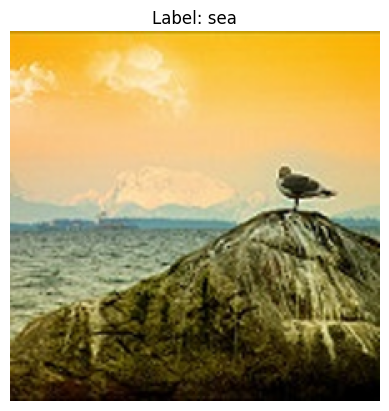

In [35]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

#### Build DesNet Model

In [38]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, growth_race):
        super(BottleneckBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_race, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_race)
        self.conv2 = nn.Conv2d(4 * growth_race, growth_race, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x.clone().detach()
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = torch.cat([res, x], dim=1)
        return x

In [39]:
class DenseBlock(nn.Module):
    def __init__(self, n_layers, in_channels, growth_race):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(n_layers):
            layers.append(BottleneckBlock(in_channels + i * growth_race, growth_race))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [40]:
class DenseNet(nn.Module):
    def __init__(self, n_blocks, growth_rate, n_classes):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(2 * growth_rate)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.dense_blocks = nn.ModuleList()
        in_channels = 2 * growth_rate
        for i, n_layers in enumerate(n_blocks):
            self.dense_blocks.append(DenseBlock(n_layers, in_channels, growth_rate))
            in_channels += n_layers * growth_rate
            if i != len(n_blocks) - 1:
                out_channels = in_channels // 2
                self.dense_blocks.append(nn.Sequential(
                    nn.BatchNorm2d(in_channels),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                    nn.AvgPool2d(kernel_size=2, stride=2)
                ))
                in_channels = out_channels

        self.bn2 = nn.BatchNorm2d(in_channels)
        self.pool2 = nn.AvgPool2d(kernel_size=7)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_channels, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)

        for block in self.dense_blocks:
            x = block(x)

        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [41]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = DenseNet(
    [6, 12, 24, 16],
    growth_rate=32,
    n_classes=n_classes
).to(device)

cuda


#### Create Model Evaluate Function

In [42]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    loss = sum(losses) / len(losses)
    return accuracy, loss

In [43]:
def train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_accuracy, val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:\tTrain Loss: {train_loss:.4f}\tVal Loss: {val_loss:.4f}\tVal Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses

In [44]:
lr = 1e-2
epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, device, epochs)

Epoch 1/15:	Train Loss: 1.4425	Val Loss: 1.2655	Val Accuracy: 55.86%
Epoch 2/15:	Train Loss: 1.2185	Val Loss: 1.1502	Val Accuracy: 58.53%
Epoch 3/15:	Train Loss: 1.1314	Val Loss: 1.0823	Val Accuracy: 60.06%
Epoch 4/15:	Train Loss: 1.0708	Val Loss: 1.0255	Val Accuracy: 63.70%
Epoch 5/15:	Train Loss: 1.0228	Val Loss: 0.9732	Val Accuracy: 65.16%
Epoch 6/15:	Train Loss: 0.9754	Val Loss: 0.9320	Val Accuracy: 65.44%
Epoch 7/15:	Train Loss: 0.9287	Val Loss: 0.8875	Val Accuracy: 68.08%
Epoch 8/15:	Train Loss: 0.8887	Val Loss: 0.8525	Val Accuracy: 70.15%
Epoch 9/15:	Train Loss: 0.8565	Val Loss: 0.8212	Val Accuracy: 71.64%
Epoch 10/15:	Train Loss: 0.8208	Val Loss: 0.8015	Val Accuracy: 71.54%
Epoch 11/15:	Train Loss: 0.7921	Val Loss: 0.7797	Val Accuracy: 72.78%
Epoch 12/15:	Train Loss: 0.7622	Val Loss: 0.7609	Val Accuracy: 72.92%
Epoch 13/15:	Train Loss: 0.7333	Val Loss: 0.7267	Val Accuracy: 74.24%
Epoch 14/15:	Train Loss: 0.7038	Val Loss: 0.6885	Val Accuracy: 75.56%
Epoch 15/15:	Train Loss: 0.67

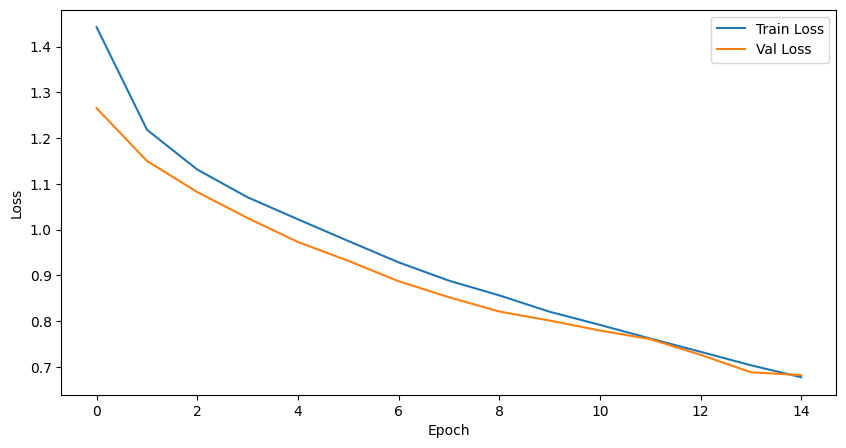

In [45]:
# Visualize
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
# Model Evaluation
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset")
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)

Evaluation on val/test dataset
Val accuracy: 0.6822014338100738
Test accuracy: 0.7088989904224873
